In [1]:
import tensorflow as tf
print("imported tensorflow")
import os
print("imported os")
import matplotlib
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np

imported tensorflow
imported os


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

for gpu in gpus:
    gpu = tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
data = 'Dataset'
os.listdir(data)

image_exts = ['jpeg', 'jpg', 'bmp', 'png','JPEG','PNG','BMP'] 

In [4]:
for main_category in os.listdir(data):
    main_category_path = os.path.join(data, main_category)
    
    # Skip if not a directory
    if not os.path.isdir(main_category_path):
        continue
    
    # Loop through rock types (Basalt, Granite, etc.)
    for rock_type in os.listdir(main_category_path):
        rock_type_path = os.path.join(main_category_path, rock_type)
        
        # Skip if not a directory
        if not os.path.isdir(rock_type_path):
            continue
        
        # Loop through actual images
        for image in os.listdir(rock_type_path):
            image_path = os.path.join(rock_type_path, image)
            
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {} - {}'.format(image_path, e))



print("Issues resolved")

Issues resolved


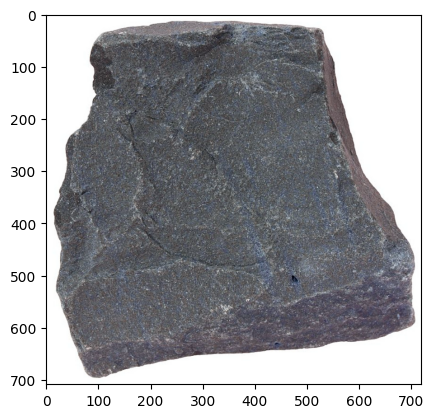

In [5]:
img = cv2.imread(os.path.join('Dataset','Igneous','Basalt','2.jpg'))
plt.imshow(img)
plt.show()

In [32]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [33]:
data = tf.keras.utils.image_dataset_from_directory('Dataset') #ts is a pipeline

Found 1988 files belonging to 3 classes.


In [27]:
data_iterator = data.as_numpy_iterator()
data_iterator

In [28]:
batch = data_iterator.next()


In [29]:
print(f"Batch length = {len(batch)}")


Batch length = 2


In [30]:
batch[0].shape

(32, 256, 256, 3)